In [5]:
import numpy as np 
import pandas as pd 
import geopy


import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from geopy.distance import geodesic
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
RANDOM_SEED = 42

In [7]:
# fix the version of the packages so that the experiments are reproducible:
!pip freeze > requirements.txt

In [8]:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv('submission.csv') # самбмишн

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [14]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [15]:
#sample_submission.head()

In [16]:
#sample_submission.info()

In [17]:
# for correct processing of attributes we combine train and test in one dataset
df_train['sample'] = 1 # train
df_test['sample'] = 0 # test
df_test['reviewer_score'] = 0 # We don't have a reviewer_score value in the test, we have to predict it, so for now we just fill it with zeros.

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # merge

C:\Users\Карина\AppData\Local\Temp\ipykernel_25068\3245005074.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # merge


In [18]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [19]:
# fill in the missing values with the median values of the columns
imputer = SimpleImputer(strategy='median')
hotels[['lat', 'lng']] = imputer.fit_transform(hotels[['lat', 'lng']])

In [20]:
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
dtype: int64

In [21]:
# Let's sort attributes with object type
object_columns = [col for col in hotels.columns if hotels[col].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

1. Design of features

Преобразование признака 'hotel_address'

In [22]:
# Convert 'hotel_address' feature
hotels['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [23]:
# Let's extract the country from 'hotel_address'
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])

# Rename 'Kingdom' -> 'United Kingdom'.
hotels.loc[hotels['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# see what values are represented
hotels['hotel_country'].value_counts()['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])

# Rename 'Kingdom' -> 'United Kingdom'.
hotels.loc[hotels['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# see what values are represented
hotels['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [24]:
# Let's extract the city from 'hotel_address'
hotels['hotel_city'] = hotels['hotel_address'].apply \
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

# see what values are represented
hotels['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [25]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

2. Categorization of attributes

In [26]:
#encode hotel_country
#encode hotel_country attribute
hotels = pd.get_dummies(hotels, columns=['hotel_country'])

# let's see what we got
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,sample,reviewer_score,hotel_city,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,9.171102,0,0.0,Milan,0,0,1,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,4.834443,0,0.0,Amsterdam,0,0,0,1,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,2.161520,0,0.0,Barcelona,0,0,0,0,1,0


In [27]:
# It turns out that we only have hotel data for one city in each country. So we can remove one of these attributes.
# Let's remove the address and city attributes.

hotels.drop(['hotel_city', 'hotel_address'], axis=1 , inplace=True)

Conversion of 'rewiew_date' feature

In [28]:
# Create an attribute denoting the number of the month in which the review was left.

# Create a dictionary with months
month_dict = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12}

# Create a new 'season' feature based on the 'review_date' feature
hotels['review_date'] = pd.to_datetime(hotels['review_date']) 
hotels['month'] = hotels['review_date'].dt.month.map(month_dict) 
hotels['season'] = 'unknown' 
hotels.loc[hotels['month'].isin([12,1,2]), 'season'] = 'winter' 
hotels.loc[hotels['month'].isin([3,4,5]), 'season'] = 'spring' 
hotels.loc[hotels['month'].isin([6,7,8]), 'season'] = 'summer' 
hotels.loc[hotels['month'].isin([9,10,11]), 'season'] = 'autumn' 

print(hotels[['review_date', 'season']].head())

  review_date  season
0  2017-07-21  summer
1  2016-12-12  winter
2  2015-11-26  autumn
3  2015-10-17  autumn
4  2016-05-16  spring


In [29]:
hotels['review_date'].describe()

C:\Users\Карина\AppData\Local\Temp\ipykernel_25068\3709708957.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hotels['review_date'].describe()


count                  515738
unique                    731
top       2017-08-02 00:00:00
freq                     2585
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

In [30]:
hotels.drop('review_date', axis=1 , inplace=True)

Преобразовав признак «tags» с помощью TfidfVectorizer, мы можем извлечь дополнительную информацию об описании отелей, которая может быть полезна для модели. Для этого каждому слову в тексте присваивается вес в зависимости от его частоты в документе и во всем корпусе. Этот вес отражает важность слова в документе, причем более важные слова имеют больший вес. Это может помочь модели лучше понять взаимосвязь между описаниями отелей и оценками в отзывах и, в конечном итоге, привести к более точным прогнозам.

In [31]:
# Create a TfidfVectorizer object with the required parameters
tfidf = TfidfVectorizer(max_features=1000)

# Convert the 'tags' column to a TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(hotels['tags'])

# Get the trait names
feature_names = tfidf.get_feature_names_out()

# Output the TF-IDF matrix and feature names
print(tfidf_matrix)
print(feature_names)


  (0, 378)	0.4215381985417224
  (0, 546)	0.28660413664137474
  (0, 482)	0.3147195800731594
  (0, 184)	0.4386277267409242
  (0, 154)	0.4913436540289804
  (0, 590)	0.2949656808910538
  (0, 310)	0.34683941532767265
  (1, 377)	0.3023206766920845
  (1, 591)	0.760966980843738
  (1, 249)	0.468121404806162
  (1, 546)	0.15277890821020718
  (1, 482)	0.16776629395310297
  (1, 590)	0.15723616279273883
  (1, 310)	0.1848882846528277
  (2, 175)	0.23159063853000272
  (2, 352)	0.23157922294786729
  (2, 234)	0.23152414235060254
  (2, 553)	0.23159063853000272
  (2, 596)	0.3573326320475919
  (2, 585)	0.3906642472616343
  (2, 525)	0.3906642472616343
  (2, 105)	0.43014226961012253
  (2, 377)	0.3022712236063134
  (2, 546)	0.15275391690450357
  (2, 482)	0.1677388510371399
  :	:
  (515735, 513)	0.5959851017613892
  (515735, 585)	0.3867814947963543
  (515735, 525)	0.3867814947963543
  (515735, 105)	0.4258671510922222
  (515735, 377)	0.29926699594312883
  (515735, 546)	0.1512357189849358
  (515735, 482)	0.166071

In [32]:
hotels.head()

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,sample,reviewer_score,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,month,season
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0.0,0,0,1,0,0,0,7,summer
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0.0,0,0,0,1,0,0,12,winter
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,0,0.0,0,0,0,0,1,0,11,autumn
3,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,0,0.0,0,0,1,0,0,0,10,autumn
4,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,0,0.0,0,0,0,1,0,0,5,spring


Transforming the 'reviewer_nationality' feature. The 'nationality_mean_score' feature is useful to the model because it encodes the categorical feature 'reviewer_nationality' based on the average review score for reviews left by certain nationalities. This gives the model additional information about which nationalities tend to leave higher or lower scores.

In [33]:
# Coding of the 'reviewer_nationality' categorical attribute based on the mean value
nationality_mean = hotels.groupby('reviewer_nationality')['average_score'].transform('mean')
hotels['nationality_mean_score'] = nationality_mean

In [34]:
print(hotels[['reviewer_nationality', 'average_score', 'nationality_mean_score']].head())

         reviewer_nationality  average_score  nationality_mean_score
0             United Kingdom             8.1                8.377914
1                    Belgium             8.6                8.430907
2                     Sweden             8.3                8.379958
3   United States of America             9.1                8.537303
4             United Kingdom             9.1                8.377914


These attributes can help the model identify keywords that influence how users rate hotels. For example, if many positive reviews contain the word "good", this may be a good indicator that the hotel has high ratings. Similarly, if many negative reviews contain the word "terrible", this may be an indication of low ratings for the hotel.

In [35]:
hotels.drop(['reviewer_nationality'], axis=1 , inplace=True)

In [36]:
hotels.head()

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,reviewer_score,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,month,season,nationality_mean_score
0,904,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,0.0,0,0,1,0,0,0,7,summer,8.377914
1,612,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,0.0,0,0,0,1,0,0,12,winter,8.430907
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",...,0.0,0,0,0,0,1,0,11,autumn,8.379958
3,241,9.1,Hotel Principe Di Savoia,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",...,0.0,0,0,1,0,0,0,10,autumn,8.537303
4,834,9.1,Hotel Esther a,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",...,0.0,0,0,0,1,0,0,5,spring,8.377914


Преобразование признаков 'lat' и 'lng'

In [37]:
# coordinates of the city center or tourist attraction
city_center = (48.8566, 2.3522) 

def distance_to_location(row):
    hotel_location = (row['lat'], row['lng'])
    return geodesic(city_center, hotel_location).km

hotels['distance_to_city_center'] = hotels.apply(distance_to_location, axis=1)

In [38]:
hotels.drop(['lat', 'lng'], axis=1 , inplace=True)

In [39]:
hotels.head()

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,month,season,nationality_mean_score,distance_to_city_center
0,904,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,0,0,1,0,0,0,7,summer,8.377914,634.839831
1,612,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,0,0,0,1,0,0,12,winter,8.430907,430.018900
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",...,0,0,0,0,1,0,11,autumn,8.379958,829.574964
3,241,9.1,Hotel Principe Di Savoia,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",...,0,0,1,0,0,0,10,autumn,8.537303,640.046962
4,834,9.1,Hotel Esther a,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",...,0,0,0,1,0,0,5,spring,8.377914,430.081272


Преобразование признаков 'positive_review', 'negative_review'

In [40]:
hotels['positive_review_contains_good'] = hotels['positive_review'].str.contains('good', case=False)
hotels['negative_review_contains_terrible'] = hotels['negative_review'].str.contains('terrible', case=False)

In [41]:
hotels.drop(['positive_review', 'negative_review'], axis=1 , inplace=True)

Корреляция признаков

C:\Users\Карина\AppData\Local\Temp\ipykernel_25068\2924272731.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.corr(method = 'spearman'), annot = True, cmap='PiYG')


Text(0.5, 1.0, 'Корреляция Спирмена')

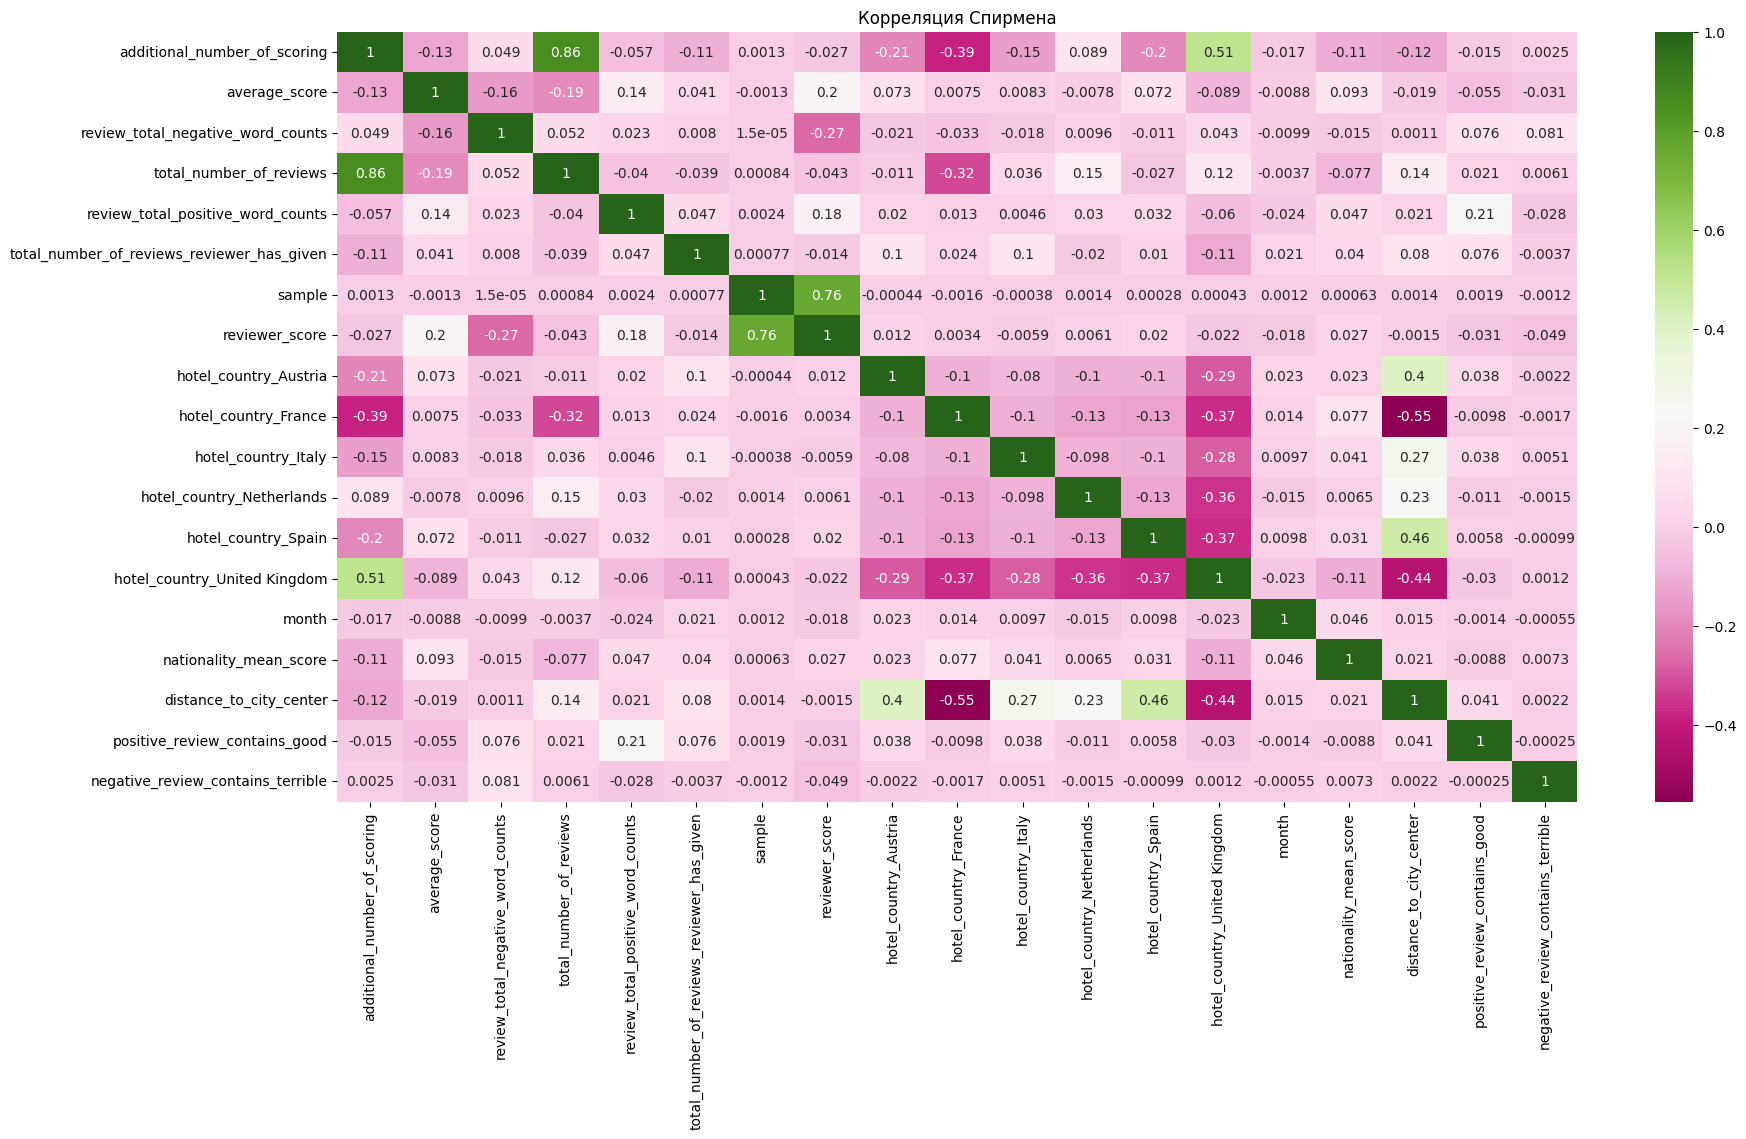

In [42]:
# construct the thermal correlation matrix
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(hotels.corr(method = 'spearman'), annot = True, cmap='PiYG')
plt.title('Корреляция Спирмена')

In [43]:
# there is a strong direct correlation between "additional_number_of_scoring" and "total_number_of_reviews", let's remove one of these features
drop_list = ['additional_number_of_scoring']
hotels.drop(drop_list, axis=1 , inplace=True)
hotels.head(3)

,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,...,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,month,season,nationality_mean_score,distance_to_city_center,positive_review_contains_good,negative_review_contains_terrible
0,8.1,Hotel Da Vinci,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,...,1,0,0,0,7,summer,8.377914,634.839831,True,False
1,8.6,Urban Lodge Hotel,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,...,0,1,0,0,12,winter,8.430907,430.018900,False,False
2,8.3,Alexandra Barcelona A DoubleTree by Hilton,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,...,0,0,1,0,11,autumn,8.379958,829.574964,False,False


In [44]:
# let's look at some basic information about non-numeric features
hotels.describe(include='object')

,hotel_name,tags,days_since_review,season
count,515738,515738,515738,515738
unique,1492,55242,731,4
top,Britannia International Hotel Canary Wharf,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,summer
freq,4789,5101,2585,142886


In [45]:
hotels.nunique(dropna=False)

average_score                                    34
hotel_name                                     1492
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
tags                                          55242
days_since_review                               731
sample                                            2
reviewer_score                                   38
hotel_country_Austria                             2
hotel_country_France                              2
hotel_country_Italy                               2
hotel_country_Netherlands                         2
hotel_country_Spain                               2
hotel_country_United Kingdom                      2
month                                            12
season                                            4
nationality_mean_score                          204
distance_to_

C:\Users\Карина\AppData\Local\Temp\ipykernel_25068\3914630029.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)


<AxesSubplot: >

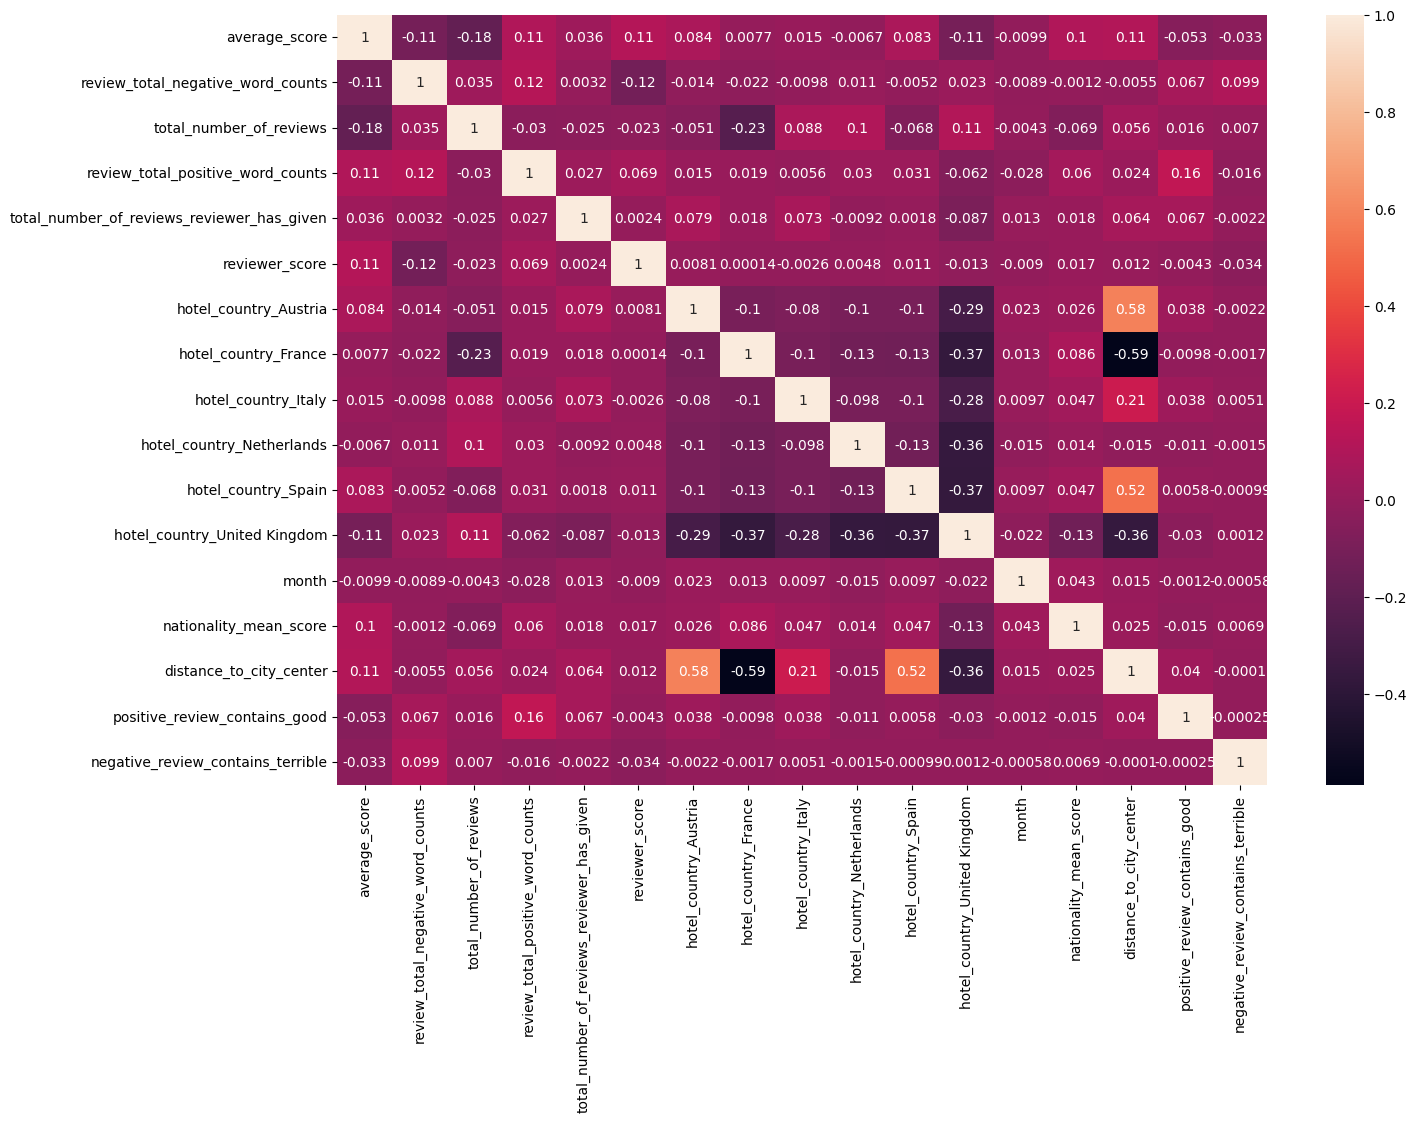

In [46]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

In [47]:
# remove features that have not been processed yet, 
# the model will not be trained on features with dtypes "object", just select them and delete them.
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [48]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   hotel_country_Austria                       515738 non-null  uint8  
 8   hotel_country_France                        515738 non-null  uint8  
 9   hotel_country_Italy                         515738 non-null  uint8  
 

In [49]:
# Now let's highlight the test section
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            
X = train_data.drop(['reviewer_score'], axis=1)

In [50]:
# Use the special function train_test_split to split the test data
# allocate 20% of the data for validation (parameter test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# check
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 17), (386803, 17), (386803, 16), (309442, 16), (77361, 16))

In [52]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

In [53]:
# Create a model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [54]:
# Train the model on a test data set
model.fit(X_train, y_train)

# Save the trained model to a file
import joblib
joblib.dump(model, 'model.pkl')

# Calculate and print the size of the model file
import os
model_size = os.path.getsize('model.pkl')
print(f'Model size: {model_size} bytes')

# Use the trained model to predict the rating of hotels in the test sample.
# Record the predicted values in the variable y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Model size: 1859085345 bytes


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [55]:
# Compare the predicted values (y_pred) with the actual values (y_test), and see how different they are on average
# The metric is called Mean Absolute Error (MAE) and shows the average deviation of predicted values from actual values.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9462726895837551


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')

Mean Squared Error (MSE): 1.6078758313228751
Root Mean Squared Error (RMSE): 1.2680204380540856
R-squared (R^2): 0.3992362388064412


In [57]:
import time

n_predictions = 100  
total_time = 0

for _ in range(n_predictions):
    start_time = time.time()
    y_pred = model.predict(X_test[:1])  
    end_time = time.time()
    total_time += end_time - start_time

average_time = total_time / n_predictions

print(f'Average prediction time: {average_time} seconds')


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

Average prediction time: 0.023536391258239746 seconds


<AxesSubplot: >

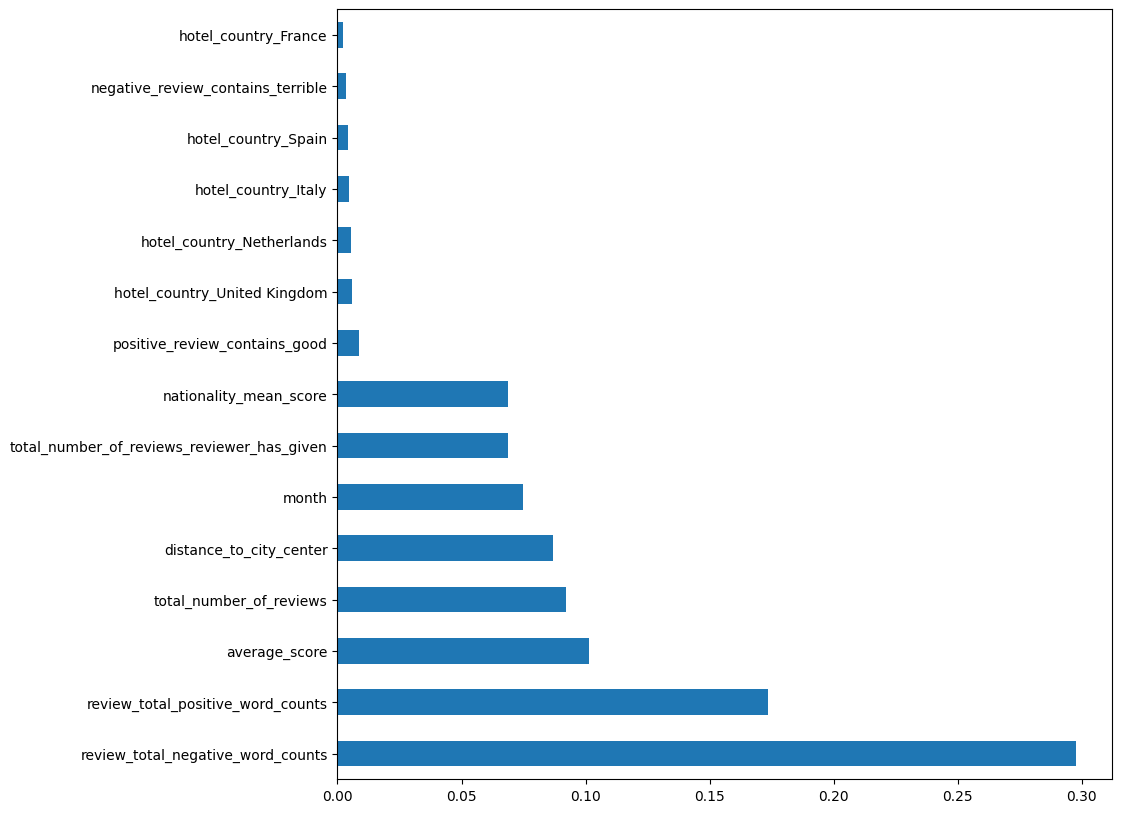

In [58]:
# in RandomForestRegressor has the ability to output the most important features for a model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [59]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,month,nationality_mean_score,distance_to_city_center,positive_review_contains_good,negative_review_contains_terrible
35008,7.8,0,1717,28,1,0.0,0,0,0,0,0,1,12,8.377914,346.314418,False,False
60790,7.8,0,388,16,2,0.0,0,0,0,0,0,1,8,8.421126,344.501381,False,False
127260,8.3,30,4684,3,1,0.0,0,0,0,0,0,1,12,8.446922,342.176201,True,False
113608,7.1,11,9086,5,1,0.0,0,0,0,0,0,1,3,8.377914,339.616230,False,False
82389,8.5,33,944,8,8,0.0,0,0,0,0,0,1,5,8.377914,356.157297,True,False
39434,7.8,13,2147,8,10,0.0,0,0,0,0,0,1,10,8.377914,343.855388,False,False
11635,8.5,0,7586,276,1,0.0,0,0,0,1,0,0,3,8.377914,430.378831,True,False
18069,7.5,2,2746,2,2,0.0,0,0,0,0,0,1,4,8.403005,344.412995,False,False
51573,8.5,20,778,0,11,0.0,0,0,0,0,1,0,5,8.353920,830.147608,False,False
6489,7.8,0,2521,7,14,0.0,0,0,0,0,1,0,9,8.377914,836.849310,False,False


In [60]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [61]:
#sample_submission

In [62]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


In [63]:
predict_submission

array([8.481, 7.229, 8.253, ..., 8.569, 9.498, 7.3  ])

In [64]:
#list(sample_submission)

In [65]:
print(predict_submission.shape)
#print(sample_submission.shape)

(128935,)


In [66]:
# sample_submission['reviewer_score'] = predict_submission
# sample_submission.to_csv('submission.csv', index=False)
# sample_submission.head(10)